# Explore TMDB data

Here we will explore the TMDB data to understand the data and the relationships between the different tables.

In [1]:
from MLConnectedWorldBook.src import tmdb_graph

import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import networkx as nx
from importlib import reload
import json
import numpy as np
from scipy.stats import ecdf
import matplotlib


reload(tmdb_graph)
%matplotlib inline

Load the data

In [2]:
dir_data = "../data/"
assert os.path.exists(dir_data)

In [3]:
df_credits = pd.read_csv(os.path.join(dir_data, "tmdb_5000_credits.csv.zip"))
df_movies = pd.read_csv(os.path.join(dir_data, "tmdb_5000_movies.csv.zip"))

## Bipartite graphs

In [4]:
%psource tmdb_graph.build_movies_and_keywords_graph

In [5]:
g_movies_and_keywords = tmdb_graph.build_movies_and_keywords_graph(
    df_movies,
)

In [6]:
print(g_movies_and_keywords)
nx.write_graphml(
    g_movies_and_keywords, "/Users/boris/temp/g_movies_and_keywords.graphml"
)

Graph with 36620 nodes and 47807 edges


the above graph contains two types of nodes. Such graphs are called **bipartite graphs** ("bi" - two, "partite" - partitions). 

We can **project** the graph to a graph with only one type of node. Here we will project the graph to a graph with only movie nodes.

In [7]:
movie_nodes = [
    n for n, d in g_movies_and_keywords.nodes(data=True) if d["type"] == "MOVIE"
]
g_movies_by_keywords = nx.bipartite.weighted_projected_graph(
    g_movies_and_keywords, movie_nodes
)
nx.write_graphml(g_movies_by_keywords, "/Users/boris/temp/g_movies_by_keywords.graphml")
print(g_movies_by_keywords)

Graph with 4800 nodes and 177827 edges


The edges in the above graph represent movies that share at least one keyword. The weight of the edge is the number of keywords shared by the two movies.

In [8]:
tmp = [(u, v, d["weight"]) for u, v, d in g_movies_by_keywords.edges(data=True)]
tmp = (
    pd.DataFrame(tmp, columns=["movie1", "movie2", "weight"])
    .sort_values("weight", ascending=False)
    .head(10)
)
tmp

movie1                 movie2  weight
141478              Project X     There Goes My Baby       6
177098  Detention of the Dead  Sunday School Musical       5
41118            The Sentinel          The Bodyguard       5
88158     The Next Three Days            Rabbit Hole       5
139413         Find Me Guilty       The Perfect Game       4
57578                Cellular           Just My Luck       4
49920          22 Jump Street         21 Jump Street       4
173800           River's Edge  Detention of the Dead       4
113534              You Again     There Goes My Baby       4
128942    Hachi: A Dog's Tale         Find Me Guilty       4

**Your turn**: 
1. Greate a graph with only keyword nodes.
2. Plot the log-log degree distribution of the above graphs.

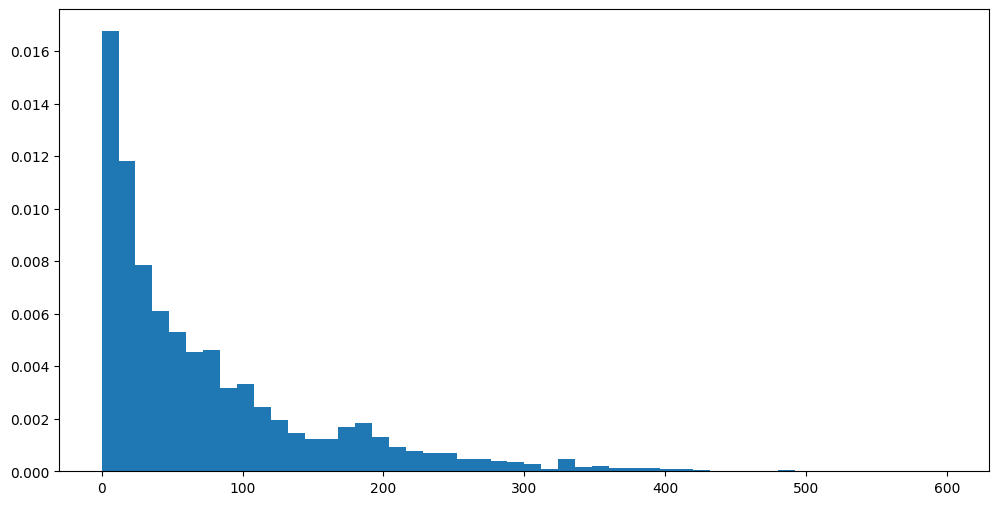

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
degrees = np.array([d for n, d in g_movies_by_keywords.degree])
ax.hist(degrees, bins=50, density=True);

## Multi-partite graphs are knolwedge graphs

We saw a graph with two types of nodes. We can have graphs with more than two types of nodes. Such graphs are called **multi-partite graphs**.

In [74]:
df_movies = pd.read_csv(os.path.join(dir_data, "tmdb_5000_movies.csv.zip"))
df_credits.head()

movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

In [11]:
%psource tmdb_graph.get_graph_with_credit_info

In [44]:
g_multi = tmdb_graph.get_graph_with_credit_info(
    g_movies_and_keywords, df_credits, top_n_cast=5
)

Processing credits:   0%|          | 0/4803 [00:00<?, ?it/s]

Adding edges:   0%|          | 0/50495 [00:00<?, ?it/s]

In [45]:
print(g_multi)

MultiGraph with 56496 nodes and 94918 edges


The graph has multiple node types:

In [75]:
pd.Series(
    [d["type"] for n, d in g_multi.nodes(data=True)], name="node types"
).value_counts()

node types
KEYWORD    31820
PERSON     19876
MOVIE       4800
Name: count, dtype: int64

... and multiple edge types. These types are also called **edge keys**. 

In [76]:
pd.Series([k for u, v, k in g_multi.edges(keys=True)], name="edge keys").value_counts()

edge keys
HAS_KEYWORD        47807
PARTICIPATED_IN    27758
WORKED_ON          19353
Name: count, dtype: int64

**Your turn**:
1. What person PARTICIPATED_IN the most movies?
2. What person WORKED_ON the most movies?


In [77]:
...

Ellipsis

We can now ask more complex questions, for example, who WORKED_ON and PARTICIPATED_IN the same movie?

In [78]:
res = []
for n in g_multi.nodes:
    if g_multi.nodes[n]["type"] == "PERSON":
        neighbors = list(g_multi.neighbors(n))
        worked_on = set()
        participated_in = set()
        for m in neighbors:
            if g_multi.has_edge(n, m, "WORKED_ON"):
                worked_on.add(m)
            if g_multi.has_edge(n, m, "PARTICIPATED_IN"):
                participated_in.add(m)

        both = worked_on.intersection(participated_in)
        any = worked_on.union(participated_in)
        if both:
            res.append((n, len(both), len(any)))
res = pd.DataFrame(res, columns=["person", "both", "any"]).sort_values(
    "both", ascending=False
)
res

person  both  any
198         Woody Allen    14   23
155        Adam Sandler    12   35
139  Sylvester Stallone    11   28
189      Clint Eastwood    11   26
10        Kevin Costner    10   26
..                  ...   ...  ...
188      David Duchovny     1    9
186       Ricky Gervais     1    6
184         Bonnie Hunt     1    9
183        Chris Kattan     1    6
427    Brian Herzlinger     1    1

[428 rows x 3 columns]

## Ego graphs

Ego graphs are subgraphs of a graph that contain a central node and all the nodes that are connected to the central node within a certain radius.

In [79]:
argo_ego_graph = nx.ego_graph(g_multi, "Argo", radius=1)

In [80]:
node_color_def = {"PERSON": "blue", "MOVIE": "red", "KEYWORD": "green"}

edge_color_def = {"PARTICIPATED_IN": "blue", "WORKED_ON": "red", "HAS_KEYWORD": "green"}

rad_def = {"PARTICIPATED_IN": 0.1, "WORKED_ON": 0.2, "HAS_KEYWORD": 0.3}
node_colors = [node_color_def[g_multi.nodes[n]["type"]] for n in argo_ego_graph.nodes]
edge_colors = [edge_color_def[k] for u, v, k in argo_ego_graph.edges]

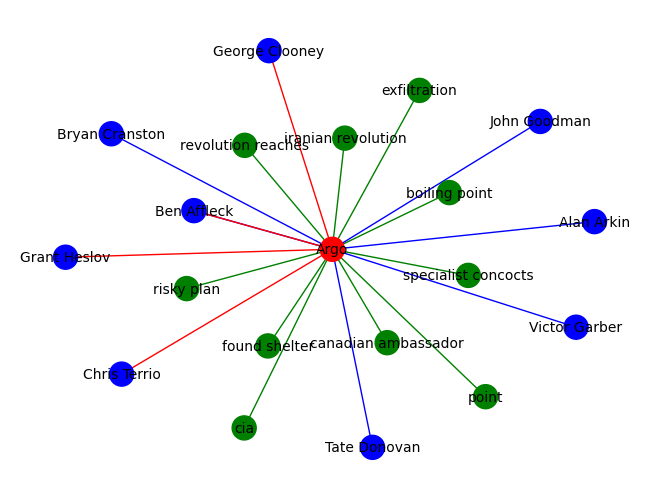

In [81]:
nx.draw(
    argo_ego_graph,
    labels={n: n for n in argo_ego_graph.nodes},
    node_color=node_colors,
    edge_color=edge_colors,
    font_size=10,
)

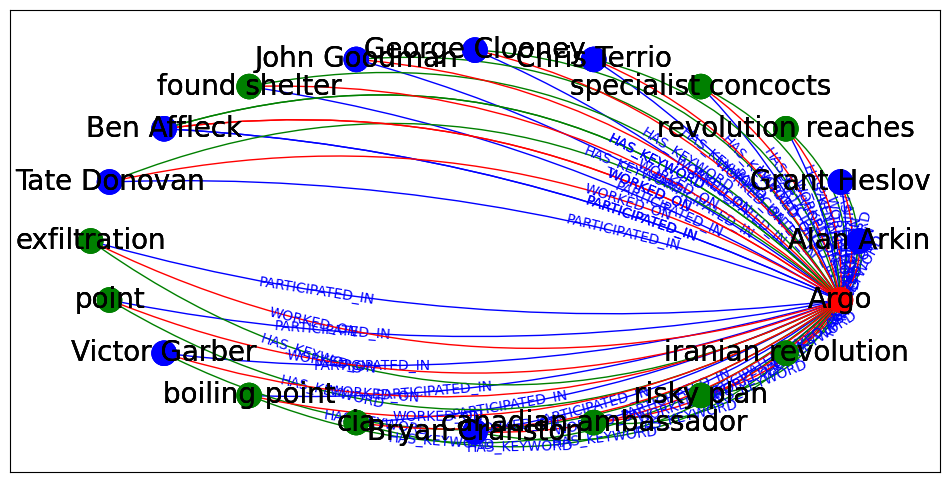

In [82]:
def draw_labeled_multigraph(G, attr_name, node_colors=None, edge_color=None, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.

    Based on https://networkx.org/documentation/stable/auto_examples/drawing/plot_multigraphs.html
    """
    import itertools as it

    if ax is None:
        ax = plt.gca()
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = f"arc3,rad={rad_def[attr_name]}"

    if not edge_color:
        edge_color = "black"
    if not node_colors:
        node_colors = "black"

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color=edge_color, connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}" for *edge, attrs in G.edges(keys=True, data=True)
    }

    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )
    return ax


edge_keys = set([k for u, v, k in argo_ego_graph.edges(keys=True)])
fig, ax = plt.subplots(figsize=(12, 6))
for k in edge_keys:
    draw_labeled_multigraph(
        argo_ego_graph, k, ax=ax, node_colors=node_colors, edge_color=edge_color_def[k]
    )

## Graph-based recommendations

Let's go back to the graph of movies connected by keywords. For presentation purposes, let's keep only top-N earning movies

In [83]:
movies_to_keep = (
    df_movies.sort_values("revenue", ascending=False).head(500).title.values
)
movies_to_drop = [m for m in g_movies_by_keywords.nodes if m not in movies_to_keep]
g_movies_trimmed = g_movies_by_keywords.copy()
g_movies_trimmed.remove_nodes_from(movies_to_drop)
print(g_movies_trimmed)

Graph with 500 nodes and 1691 edges


In [85]:
# # We can also keep only the top-N neighbors of each node, if we want to reduce the size of the graph
# N = 5
# for m in g_movies_trimmed.nodes:
#     neighbors = sorted(
#         g_movies_trimmed.neighbors(m),
#         key=lambda x: g_movies_trimmed.edges[m, x]["weight"],   # sort by the weight of the edge
#         reverse=True
#     )
#     for n in neighbors[N:]:
#         g_movies_trimmed.remove_edge(m, n)
# g_movies_trimmed = tmdb_graph.remove_isolated_nodes(g_movies_trimmed) # NOTE: this is not necessary, but it is good practice
# print(g_movies_trimmed)

In [93]:
# community detection
communities = nx.algorithms.community.louvain_communities(
    g_movies_trimmed, resolution=0.5, weight="weight"
)
# sort communities by sizes
communities = sorted(communities, key=lambda x: len(x), reverse=True)
print(f"Originally Found {len(communities)} communities")
print(f"We will remove smaller communities for better visualization")
for i, c in enumerate(communities):
    for m in c:
        g_movies_trimmed.nodes[m]["community"] = i
        if i < 10:
            clr = f"C{i}"
        else:
            clr = "gray"
        g_movies_trimmed.nodes[m]["color"] = clr

g_movies_trimmed = tmdb_graph.get_largest_connected_component_graph(g_movies_trimmed)
print(g_movies_trimmed)
for u, v, d in g_movies_trimmed.edges(data=True):
    c1 = g_movies_trimmed.nodes[u]["community"]
    c2 = g_movies_trimmed.nodes[v]["community"]
    if c1 == c2:
        d["color"] = f"C{c1}"
        d["weight"] = d["weight"] * 2
    else:
        d["color"] = "gray"
    # convert the color to rgb and add 50% transparency using matplotlib.colors
    clr = d["color"]
    r, g, b = matplotlib.colors.to_rgb(clr)
    d["color"] = (r, g, b, 0.5)

Originally Found 25 communities
We will remove smaller communities for better visualization
Graph with 397 nodes and 668 edges


In [115]:
layout = nx.spring_layout(g_movies_trimmed, weight="weight")

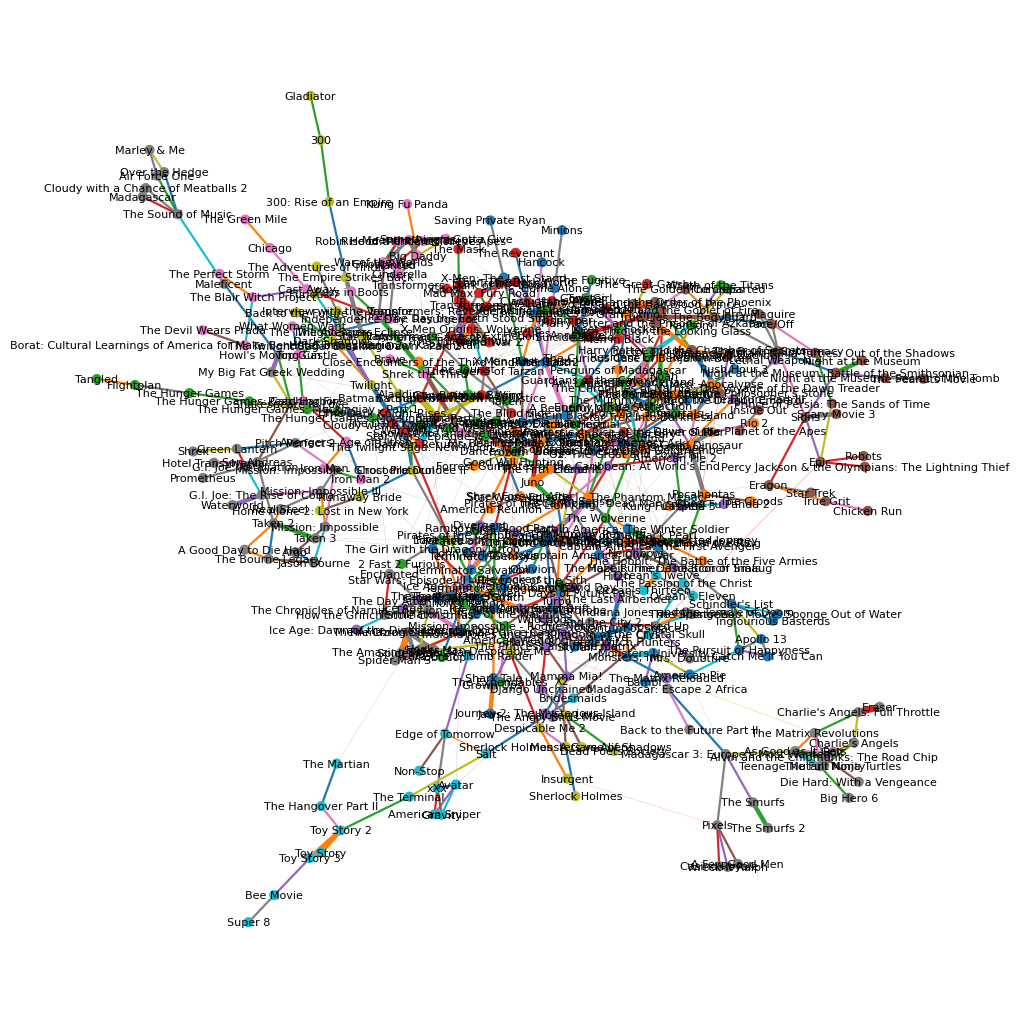

In [116]:
# draw the graph, showing the movie titles
plt.figure(figsize=(10, 10))
nx.draw(
    g_movies_trimmed,
    layout,
    labels={n: n for n in g_movies_trimmed.nodes},
    node_size=40,
    node_color=[g_movies_trimmed.nodes[m]["color"] for m in g_movies_trimmed.nodes],
    width=[d["weight"] / 10 for u, v, d in g_movies_trimmed.edges(data=True)],
    edge_color=[g_movies_trimmed.nodes[m]["color"] for m in g_movies_trimmed.nodes],
    font_size=8,
)

Let's say, I like the movie "Sherlock Holmes". I can use the above graph to find similar movies.

In [117]:
m1 = "Sherlock Holmes"
neighbors = sorted(
    g_movies_trimmed.neighbors(m1),
    key=lambda x: g_movies_trimmed.edges[m1, x][
        "weight"
    ],  # sort by the weight of the edge
    reverse=True,
)
for n in neighbors:
    weight = g_movies_trimmed.edges[m1, n]["weight"]
    print(f"{n}: {weight:.2f}")

Sherlock Holmes: A Game of Shadows: 16.00


There is only one movie that shares a keyword with "Sherlock Holmes". Let's expand the search to the neighbors of the neighbors.

DiGraph with 14 nodes and 13 edges


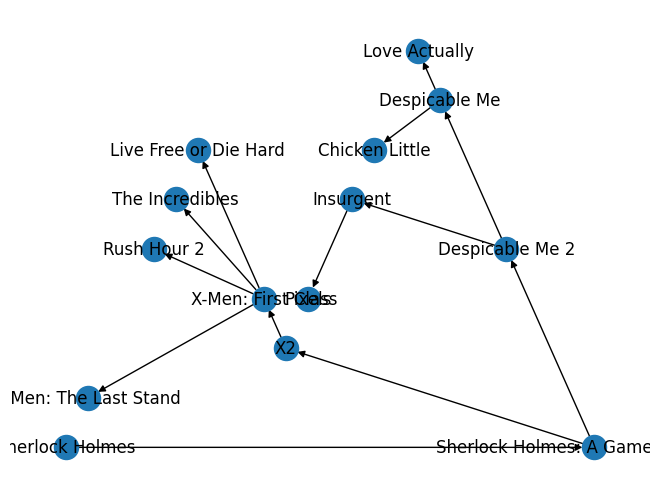

In [118]:
radius = 4
movie_tree = nx.dfs_tree(g_movies_trimmed, m1, depth_limit=radius)
print(movie_tree)
nx.draw(movie_tree, pos=nx.planar_layout(movie_tree), with_labels=True)

(note that the above graph a directed graph, where the direction of the edges is from the parent to the child)

Now, we'll need to find the similarity between the movies. If two movies are adjacent to a common movie, we can compare the edge weights to find the similarity. If two movies are not adjacent to a common movie, we to compute a distance. For that, we will use a simple heuristic: the distance of an edge is the inverse of it's edge and the distance between two movies is the sum of the distances of the shortest path between the two movies.

In [119]:
for u, v, d in g_movies_trimmed.edges(data=True):
    d["distance"] = 1 / d["weight"]

In [120]:
neighbors = nx.dfs_tree(g_movies_trimmed, m1, depth_limit=radius).nodes
recommendations = []
for n in neighbors:
    if n == m1:
        continue
    distance = nx.shortest_path_length(
        g_movies_trimmed,
        m1,
        n,
        weight="distance",  # note the `weight` parameter
    )
    path = nx.shortest_path(g_movies_trimmed, m1, n, weight="distance")
    recommendations.append(
        (
            n,
            len(path) - 1,
            distance,
        )
    )
recommendations = (
    pd.DataFrame(recommendations, columns=["movie", "hops", "distance"])
    .sort_values("distance")
    .reset_index(drop=True)
)
recommendations

movie  hops  distance
0   Sherlock Holmes: A Game of Shadows     1    0.0625
1                                   X2     2    0.1250
2                      Despicable Me 2     2    0.1250
3                            Insurgent     3    0.1875
4                        Despicable Me     3    0.1875
5                       Chicken Little     4    0.2500
6                        Love Actually     4    0.2500
7                   X-Men: First Class     3    1.1250
8                X-Men: The Last Stand     4    1.1875
9                          Rush Hour 2     4    1.1875
10                     The Incredibles     4    1.1875
11               Live Free or Die Hard     4    1.1875
12                              Pixels     4    1.1875

Now, suppose, that my friend likes the movie "The Hunger Games". I really want him to like the movie "Sherlock Holmes" but I'm not sure if he will like it. I can use the above graph to find a sequence of movies that will connect these movies.

In [121]:
m1 = "Sherlock Holmes"
m2 = "The Hunger Games"

In [122]:
path = nx.shortest_path(g_movies_trimmed, m2, m1, weight="distance")
distance = nx.shortest_path_length(g_movies_trimmed, m1, m2, weight="distance")
print(f"Total distance: {distance:.2f}")
print(" -> ".join(path))

Total distance: 1.88
The Hunger Games -> The Hunger Games: Catching Fire -> The Hunger Games: Mockingjay - Part 1 -> The Hunger Games: Mockingjay - Part 2 -> Wild Wild West -> Dances with Wolves -> A Beautiful Mind -> Annabelle -> Twister -> A.I. Artificial Intelligence -> The Twilight Saga: New Moon -> Love Actually -> Despicable Me -> Despicable Me 2 -> Sherlock Holmes: A Game of Shadows -> Sherlock Holmes


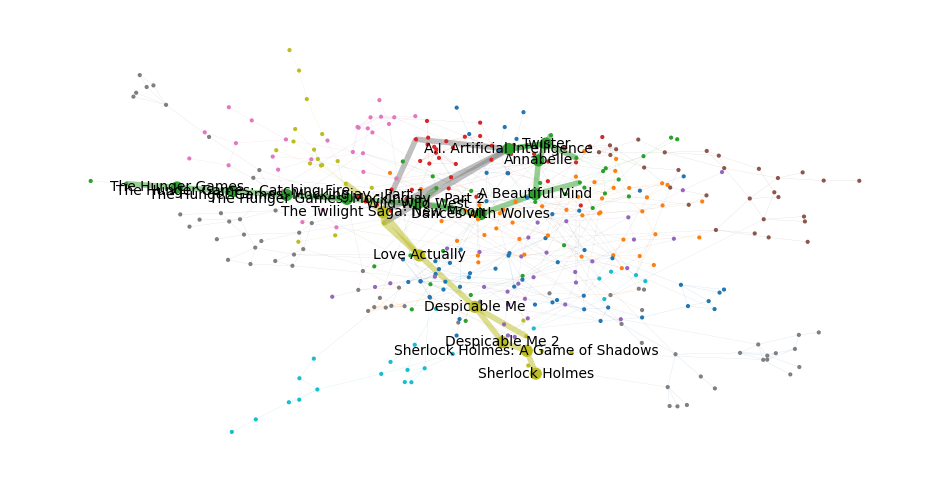

In [123]:
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(
    g_movies_trimmed,
    layout,
    labels={n: (n if n in path else "") for n in g_movies_trimmed.nodes},
    node_size=[60 if n in path else 4 for n in g_movies_trimmed.nodes],
    node_color=[g_movies_trimmed.nodes[m]["color"] for m in g_movies_trimmed.nodes],
    width=[4 if u in path else 0.1 for u, v, d in g_movies_trimmed.edges(data=True)],
    edge_color=[d["color"] for u, v, d in g_movies_trimmed.edges(data=True)],
    font_size=10,
)

**Your turn**:

Using the full graph `g_movies_by_keywords`:

1. Find the shortest path between "The Jackal" and "Shrek".
2. Which pairs of movies are more similar based on the keywords: "The Matrix Reloaded" and "My Fellow Americans" or "Amigo" and "The Simpsons Movie"?
3. Find the movie with the keyword "barbarian".
4. How many connected components are there in the graph and what are their sizes? (hint: try typing the below in a cell: `[a for a in dir(nx) if 'component' in a.lower() and 'conne' in a.lower()]`)

### Distance computation (Dijkstra's Algorithm)

Up till now, we have seen the following methods:
* searching for immediate **neighbors** (`neighbors = g_movies_trimmed.neighbors(m1)`)
* **depth-first** search with a maximum depth of `radius` (`neighbors = nx.single_source_shortest_path_length(g_movies_trimmed, m1, cutoff=radius)`). A depth-first search is a search algorithm that explores as far as possible along each branch before backtracking. You might guess that there is also a **breadth-first** search algorithm. In a breadth-first search, the algorithm starts at a node and explores all the neighbor nodes at the present depth prior to moving on to the nodes at the next depth level.
* Finding the **shortest path** between two nodes (`path = nx.shortest_path(g_movies_trimmed, m2, m1, weight="distance")`)

Finding the shortest path between two nodes is a common problem in graph theory. The most known algorithm for this task was discovered by Edsger W. Dijkstra in 1956. The algorithm works as follows:



* **Initialization**:
  * Set the distance to the starting node to zero and all other distances to infinity.
  * Mark all nodes as unvisited. Set the starting node as the current node.

* **Visit each node**:
  * For the current node, consider all of its unvisited neighbors. Calculate their tentative distances through the current node.
  * Compare the newly calculated tentative distance to the current assigned value and assign the smaller one.
  * After considering all of the unvisited neighbors of the current node, mark the current node as visited. A visited node will not be checked again.

* **Select the next node**:
  * Select the unvisited node that is marked with the smallest tentative distance, and set it as the new current node.

* **Repeat**:
  * Repeat the process of visiting each node and selecting the next node until all nodes have been visited or the smallest tentative distance among the unvisited nodes is infinity (which happens when there is no connection between the initial node and remaining unvisited nodes).

* **Termination**:
  * The algorithm ends when the destination node has been visited or all nodes have been processed. The shortest path from the starting node to the destination node can then be reconstructed by backtracking through the recorded paths.



### Semantic similarity between movie description

Until now, based our graph on connecting movies that share common keywords. Recent advances in natural language processing (NLP), specifically in Large Language Models, allow us to compute the similarity between two pieces of text. These pieces of text can be as simple as title names, movie descriptions, user reviews, or even entire scripts. Here, we will use movie descriptions as a compromise between simplicity and informativeness.

We will use the **spaCy** library, which provides a simple interface to pre-trained models for natural language processing. Spacy 

* en_core_web_sm: Smaller size, lower vector dimension (96), trained on OntoNotes 
* en_core_web_md: Medium size, larger vector dimension (300) for about 20K words, trained on OntoNotes + GloVe vectors (Common Crawl)
* en_core_web_lg: Larger size, larger vector dimension (300) for about 1M words, trained on OntoNotes + GloVe vectors (Common Crawl)

OntoNotes is a large, multilingual corpus of annotated text.  GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for obtaining vector representations for words.

In [124]:
import spacy
from statsmodels.distributions.empirical_distribution import ECDF

try:
    nlp = spacy.load("en_core_web_md")
except:
    ! python -m spacy download en_core_web_md
    nlp = spacy.load("en_core_web_md")

In [125]:
top_movies = set(
    df_movies.sort_values("popularity", ascending=False).head(500).title.values
)
movie_descriptions = [
    (m, d)
    for m, d in zip(df_movies.title.values, df_movies.overview.values)
    if m in top_movies
]

In [126]:
docs = {
    movie: nlp(str(description))
    for movie, description in tqdm(
        movie_descriptions,
        desc="Processing descriptions",
        total=len(movie_descriptions),
    )
}

Processing descriptions:   0%|          | 0/500 [00:00<?, ?it/s]

In [127]:
# Calculate similarity
similarity = []
for mi in tqdm(range(len(movie_descriptions)), desc="Calculating similarities"):
    m1 = movie_descriptions[mi][0]
    doc1 = docs[m1]
    for mj in range(mi + 1, len(movie_descriptions)):
        m2 = movie_descriptions[mj][0]
        doc2 = docs[m2]
        similarity.append((m1, m2, doc1.similarity(doc2)))

Calculating similarities:   0%|          | 0/500 [00:00<?, ?it/s]

In theory, we can keep all the similarity pairs. In practice, that would result in a too large graph. We will keep only the pairs with similarity above a certain threshold. 

There are 12972 pairs with similarity above 0.93 (10.40%)
Graph with 439 nodes and 12972 edges


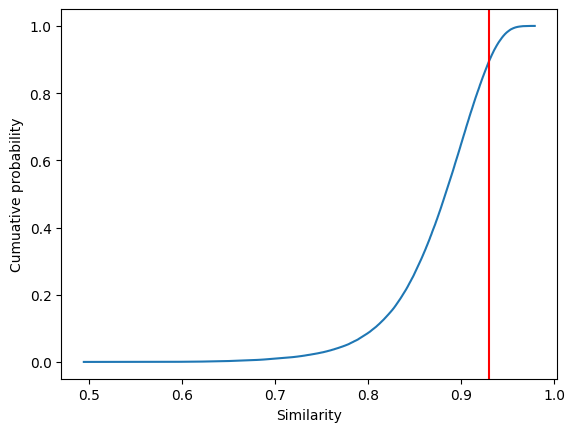

In [133]:
ecdf = ECDF([s for _, _, s in similarity])
threshold = 0.93
plt.plot(ecdf.x, ecdf.y)
plt.axvline(threshold, color="red")
plt.xlabel("Similarity")
plt.ylabel("Cumuative probability")
n_above = sum([s > threshold for _, _, s in similarity])
p_above = n_above / len(similarity) * 100
print(
    f"There are {n_above} pairs with similarity above {threshold:.2f} ({p_above:.2f}%)"
)
g_similar_movies = nx.Graph()
g_similar_movies.add_weighted_edges_from(
    [
        (m1, m2, (s + 1e-3 - threshold) / (1 - threshold))
        for m1, m2, s in similarity
        if s > threshold
    ]
)
g_similar_movies = tmdb_graph.remove_isolated_nodes(g_similar_movies)
g_similar_movies = tmdb_graph.get_largest_connected_component_graph(g_similar_movies)
print(g_similar_movies)

In [134]:
# community detection
communities = nx.algorithms.community.louvain_communities(
    g_similar_movies, resolution=1, weight="weight"
)
print(f"Found {len(communities)} communities")
for i, c in enumerate(communities):
    print(f"Community {i}: {len(c)} movies")
    for m in list(c)[:5]:
        print(f"\t{m}")
    print("...")
    for m in c:
        g_similar_movies.nodes[m]["community"] = i
        g_similar_movies.nodes[m]["color"] = f"C{i}"

df_movies["community"] = df_movies.id.map(
    {m: i for i, c in enumerate(communities) for m in c}
)

Found 6 communities
Community 0: 75 movies
	A Good Day to Die Hard
	Let's Be Cops
	21 Jump Street
	Gravity
	Gattaca
...
Community 1: 114 movies
	Groundhog Day
	Interstellar
	Green Lantern
	Charlie and the Chocolate Factory
	The Thing
...
Community 2: 74 movies
	Wanted
	Pan
	The Mummy: Tomb of the Dragon Emperor
	Terminator 2: Judgment Day
	Bruce Almighty
...
Community 3: 103 movies
	Self/less
	Prisoners
	Road to Perdition
	The Equalizer
	The Butterfly Effect
...
Community 4: 71 movies
	The Notebook
	Snowpiercer
	American Hustle
	Ex Machina
	Dredd
...
Community 5: 2 movies
	The Good, the Bad and the Ugly
	Gone with the Wind
...


In [135]:
for u, v, d in g_similar_movies.edges(data=True):
    c1 = g_similar_movies.nodes[u]["community"]
    c2 = g_similar_movies.nodes[v]["community"]
    weight = d["weight"]
    if c1 == c2:
        d["weight"] = weight * 2
        edge_color = f"C{c1}"
        d["color"] = edge_color
    else:
        d["color"] = "gray"
    # convert the color to rgb and add 50% transparency using matplotlib.colors
    clr = d["color"]
    r, g, b = matplotlib.colors.to_rgb(clr)
    d["color"] = (r, g, b, 0.5)

In [139]:
# layout = nx.spring_layout(g_similar_movies, weight="weight")
layout = nx.arf_layout(
    g_similar_movies,
)

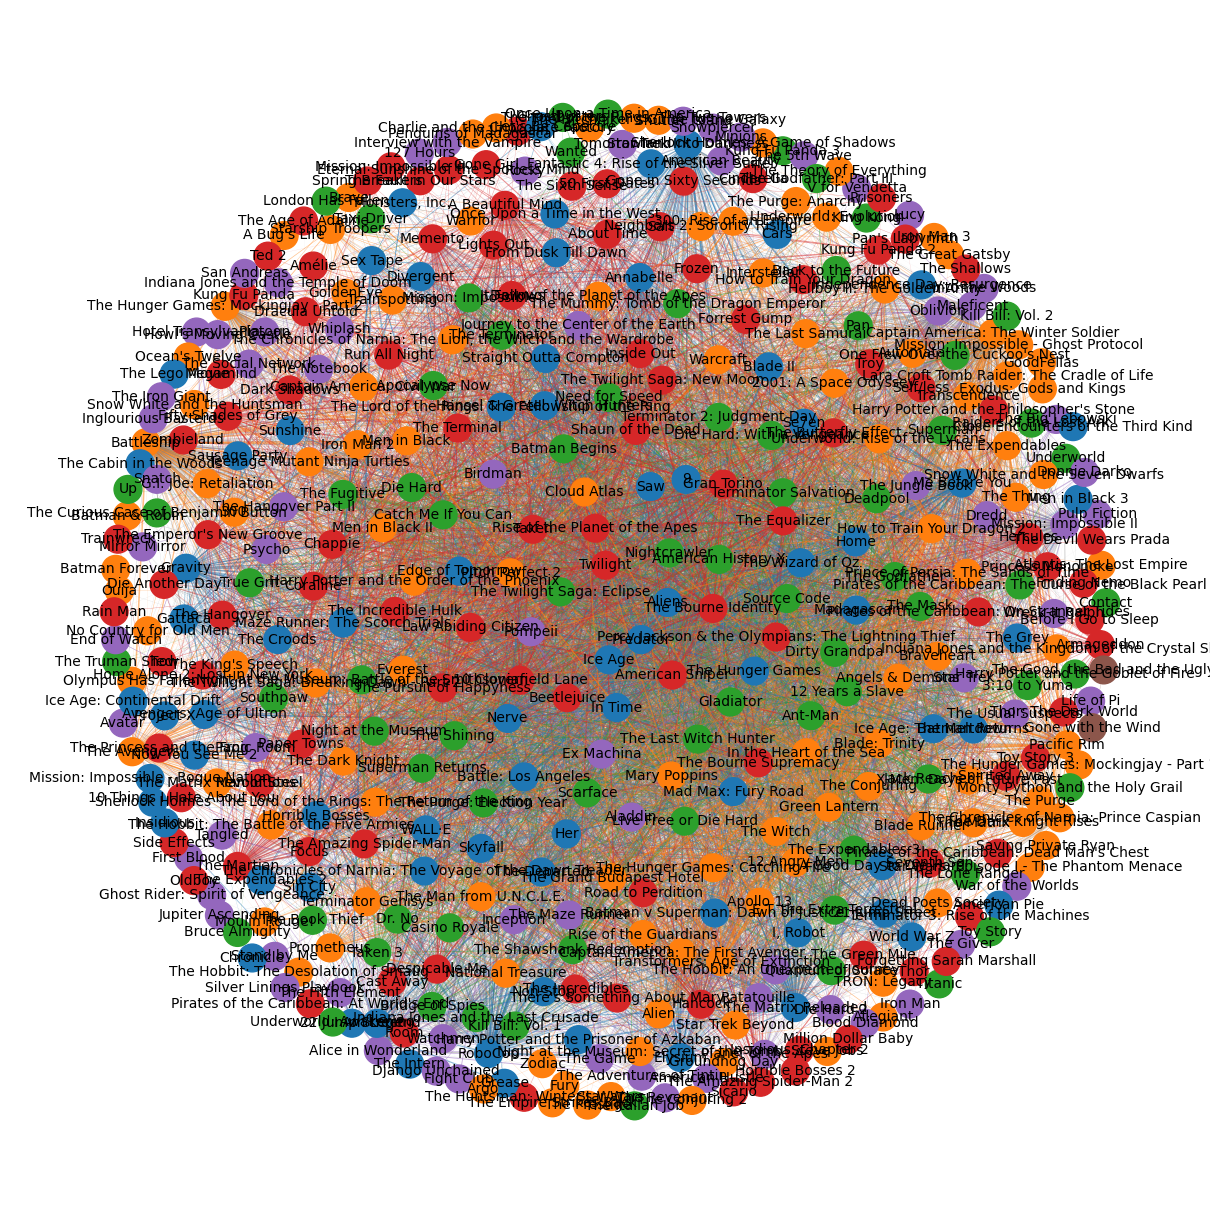

In [140]:
# draw the graph, showing the movie titles
plt.figure(figsize=(12, 12))
nx.draw(
    g_similar_movies,
    layout,
    labels={m: m for m in g_similar_movies.nodes},
    node_size=400,
    node_color=[g_similar_movies.nodes[m]["color"] for m in g_similar_movies.nodes],
    width=[d["weight"] for u, v, d in g_similar_movies.edges(data=True)],
    edge_color=[d["color"] for u, v, d in g_similar_movies.edges(data=True)],
    font_size=10,
)

In [141]:
m1 = "Sherlock Holmes"
m2 = "The Hunger Games"
path = nx.shortest_path(g_similar_movies, m2, m1, weight="weight")
distance = nx.shortest_path_length(g_similar_movies, m1, m2, weight="weight")
print(f"Total distance: {distance:.2f}")
print(" -> ".join(path))

Total distance: 0.09
The Hunger Games -> The Bourne Identity -> Ant-Man -> Sherlock Holmes


## Homework

This repository contains a file `podcasts.json`. This is a json file with subset of Hebrew-language podcasts. Each line in this file is a separate json object with the following fields:

- `title`: the title of the podcast
- `description`: a short description of the podcast
- `url`: the URL of the podcast RSS feed
- `link`: the URL of the podcast website
- `createdOn`, `newestItemPubDate`: the date the podcast was created and the date of the newest episode (seconds since epoch)
- `updateFrequency`: the frequency of the podcast updates - the higher, the more frequent
- `age_months`: the age of the podcast in months at the date of the data collection
- `stale_days`: the number of days since the last episode was published
- `title_transliterated`: the title of the podcast, automatically transliterated to Latin characters
- `description_translated`: the description of the podcast, automatically translated to English 

In [142]:
fn = "../data/podcasts.json"
pd.read_json(fn, orient="records", lines=True).head()

title  \
0                               LowBattery בלי סוללה   
1                                           גיקונומי   
2  1+1 אסף ליברמן מארח One Plus One with Asaf Lib...   
3                                             Lamzak   
4                          ONE.co.il - מספר 1 בספורט   

                                         description  \
0  שחר שושן ואהוד קינן מסכמים את חדשות הטכנולוגיה...   
1  שיחות לא קצרות, לא ערוכות ולא מצונזרות על שלל ...   
2  אסף ליברמן מזמין אורחים לשמוע ביחד מוזיקה ולדב...   
3  למז”ק - למה זה קיים? פודקאסט בו שלושה חברים שא...   
4  כל כתבות הוידיאו של אתר הספורט המוביל בישראל: ...   

                                                 url  \
0      https://lowbatteryisrael.podbean.com/feed.xml   
1  http://geekonomy.net/category/%d7%a4%d7%a8%d7%...   
2  https://www.omnycontent.com/d/playlist/23f697a...   
3                  https://www.lamzak.co.il/feed.xml   
4           https://sites.one.co.il/RSS/Video/iTunes   

                                                link   createdOn  \
0  https://feed.podbean.com/lowbatteryisrael/feed...  1596752487   
1                      https://geekonomy.podbean.com  1596752693   
2  https://www.kan.org.il/podcast/program.aspx/?p...  1597196745   
3                               https://lamzak.co.il  1597197438   
4                              https://www.ONE.co.il  1597207063   

   updateFrequency  episodeCount  newestItemPubdate  age_months  stale_days  \
0                2           344         1714280400   46.066667          15   
1                1           896         1714651648   46.066667          10   
2                3            93         1713754800   45.900000          21   
3                5           108         1713027600   45.900000          29   
4                1            50         1714082280   45.900000          17   

                                title_transliterated  \
0                               LowBattery bly svllh   
1                                           gyqvnvmy   
2  1+1 Asp lybrmn mArKH One Plus One with Asaf Li...   
3                                             Lamzak   
4                          ONE.co.il - mspr 1 bspvrt   

                              description_translated  
0  Dawn Shoechen and Ehud Kincin gather the techn...  
1  Not short conversations, unsettled and uncenso...  
2  Assaf Lieberman invites guests to hear music a...  
3  The fucker – why does it exist? Podcast has th...  
4  All of Israel’s leading sports site audio arti...

Create a Jupyter notebook that reads the `podcasts.json` file 

1. Create a bipartite graph with two types of nodes: podcasts and keywords. The edges between podcasts and keywords represent the presence of the keyword in the podcast description. The weight of the edge is the number of times the keyword appears in the description.

- rank the keywords by the sum of the weights of the edges they are connected to. What are the top-10 keywords?
- use sensible thresholds and create a podcast-podcast graph where the edges represent the similarity between the podcasts based on the keywords. The weight of the edge is the similarity between the podcasts. The graph should be small enough for you to be able to visualize it in the notebook. It should contain at least 100 podcasts. Save the graph to `podcast_keywords.graphml` file and the image to `podcast_keywords.png`.

2. Create a podcast-podcast graph where the edges represent the similarity between the podcasts based on the semantic similarity of the podcast descriptions. The weight of the edge is the similarity between the podcasts. The graph should be small enough for you to be able to visualize it in the notebook. It should contain at least 100 podcasts. Save the graph to `podcast_descriptions.graphml` file and the image to `podcast_descriptions.png`.


Submit the notebook with the code, the results, and the output files.